# My first CTMC algorithm

My first attempt at fitting a Continous Time Markov Chain to simulated data in a toy problem. Mathematical background on how to build the likelihood can be found in [here](http://www.mathematik.uni-karlsruhe.de/ianm3/~jahnke/media/medijasc2007.pdf).

### Simulate toy problem

First we will simulate some data. We will use a a simple 4 state model, a typical SIRVS epidemic model with perfect vaccination, on a closed population of 100 people.

The transitions will be defined as follows:

\begin{align}
S \to I & &\text{with rate} & &\beta \frac{SI}{N},\\
I \to R & &\text{with rate} & &\gamma \frac{I}{N},\\
R \to S & &\text{with rate} & &\omega \frac{R}{N},\\
S \to V & &\text{with rate} & &\nu \frac{SI}{N}.\\
\end{align}

For simplicity, we can define the set of parameters to be $\boldsymbol{\theta} = (\beta, \gamma, \omega, \nu)$. For our toy problem, let us set $\boldsymbol{\theta} = ( 2, 0.125, 1/400, 10)$, with an initial state (starting population) completely susceptible with 1 infected seed, i.e. $\boldsymbol{n} = (99,1, 0)$. Note that our units of time are days.

In [164]:
class sirvs:
    
    """Class object to contain the ctmc model"""
    import numpy as np
    
    def __init__(self,beta, gamma, omega, nu, init):
        self.parameters = (beta, gamma, omega,nu)
        assert len(init)==4, "Number of states given is not 4"
        self.initial = init
        self.current = list(init)
        self.totalpop = sum(init)
    
    def transition(self):
        #First define transition movements
        
        def infection():
            #Infected transmission
            self.current[0] -= 1
            self.current[1] += 1

        def recovery():
            #Recovery 
            self.current[1] -=1
            self.current[2] +=1
        def waning():
            #waning immunity
            self.current[2] -=1
            self.current[0] +=1
        def vacc():
            #vaccination
            self.current[0] -=1
            self.current[3] +=1

        #map the functions to the respective index in the transition
        map_transitions = {
            0 : infection,
            1 : recovery,
            2 : waning,
            3 : vacc,
        }

        #Calculate transitions rates
        trans = beta * self.current[0]*self.current[1]/self.totalpop
        recov = gamma * self.current[1]
        wane = omega * self.current[2]
        vac = nu * self.current[1] * self.current[0]/self.totalpop
        total = trans + recov + wane + vac
        
        #Record current rates
        self.currentrates = (trans, recov, wane, vac)
        
        #Draw a transition time
        dt = np.random.exponential(1/total)
        
        #Draw a transition
        p = np.array(self.currentrates)/total
        s = np.random.choice(4, p=p)
        map_transitions[s]() #map choice to correct transition function
        #return time to transition and what kind of transition occured
        return dt, s
    
    def simulate(self,simtime):
        time = 0
        observations = []
        while time < simtime:
            dt, s = self.transition()

            time += dt
            if time > simtime:
                continue
            else:
                S,I,R,V = self.current.copy()
                observations.append((time,dt,s,S,I,R,V))
        return observations

Now that we have our functions and simulation coded, let's run a simulation and observe a possible path for this kind of CTMC, or epidemic. Let's see how the state space looks after 20 days.

       time        dt  transition   S  I  R  V
0  0.142452  0.142452           3  94  5  0  1
1  0.360491  0.218039           0  93  6  0  1
2  0.515022  0.154531           3  92  6  0  2
3  0.521207  0.006185           3  91  6  0  3
4  0.554681  0.033475           0  90  7  0  3


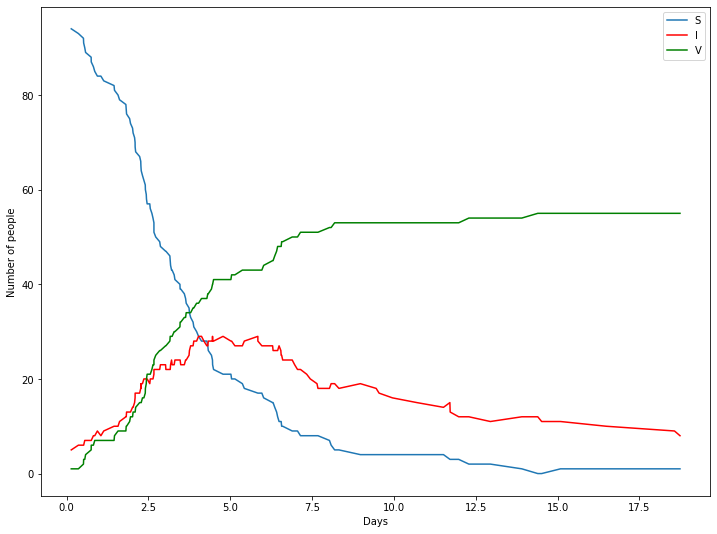

In [165]:
init = np.array((95,5,0,0))
beta = 0.7
gamma = 0.125
omega = 1/400
nu = 1

toy = sirvs(beta, gamma, omega, nu, init)
obs = toy.simulate(20)

import matplotlib.pyplot as plt
import pandas as pd
data = pd.DataFrame(obs, columns = ['time','dt','transition','S','I','R','V'])
print(data.head())
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(data.time, data.S, label='S')
ax.plot(data.time, data.I, label='I', color = 'r')
ax.plot(data.time, data.V, label='V', color='g')
ax.set_xlabel("Days")
ax.set_ylabel("Number of people")
plt.legend()
plt.show()

Now that we have our data, let's see how we would do inference. As a reminder, the parameters we want to be infering are $\boldsymbol{\theta} = (\beta, \gamma, \omega, \nu)$.

In [175]:
import pystan

stancode = """
data {
    int<lower=0> N; //length of data
    int<lower=1> Pop; //total size of population
    matrix[N,7] Obs; //Observations
    int<lower=0> transitions[N]; //transition code
}
parameters {
    real<lower=0> beta;
    real<lower=0> gamma;
    real<lower=0> omega;
    real<lower=0> nu;
}
model {
    int state;
    beta ~ lognormal(1,5);
    gamma ~ lognormal(1,2);
    omega ~ lognormal(1,2);
    nu ~ lognormal(1,2);
    
    for (n in 1:N){
        state = transitions[n];
        if (state == 0) {
            //Infection
            Obs[n,2] ~ exponential(
            beta*Obs[n,4]*Obs[n,5] / Pop
            );
            }
        else if (state == 1) {
        
        
            //Recovery
            Obs[n,2] ~ exponential(
                gamma * Obs[n,5]
            );
            }
        else if (state == 2) {
            //Waning
            Obs[n,2] ~ exponential(
                omega * Obs[n,6]
            );
            }
        else {
        
        
            Obs[n,2] ~ exponential(
                nu * Obs[n,4] * Obs[n,5]/Pop
            );
            }
    } 
}
"""

data_dict = {
    'N': data.shape[0],
    'Pop': sum(init),
    'Obs': data.values,
    'transitions': data.transition.astype(int)
}

sm = pystan.StanModel(model_code=stancode,model_name='ctmc')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL ctmc_d1b045d5984a3194e9fffdd6b9690fc4 NOW.


In [176]:
iterations = 200
chains = 2

fit = sm.sampling(data=data_dict, iter=iterations, chains=chains)

RuntimeError: Initialization failed.

In [ ]:
print(fit)

In [ ]:
init = (10,30,50)
toy = sirs(beta, gamma, omega, nu, init)
toy.transition()

In [40]:
toy.currentrates

(6.666666666666667, 3.75, 0.125, 3.3333333333333335)